# Mevsimsel Olmayan Zaman Serisi Tahminleri için Basit ARIMA Modeli

Bu zorluktaki hedefimiz, zaman serisi analizinin temel kavramlarını tek boyutlu verilere uygulamaktır

Bu zorluklarda şu adımları izleyeceğiz:
1. verileri yükleme ve görselleştirme;
2. modellerimizi eğitme ve tahminler yapma;

##  1. Veri Yükleme
Zorlukta kullanacağımız zaman serisini yükleyerek başlayalım. Veri setini CSV dosyası olarak indirmek için aşağıdaki satırı çalıştırın, ardından CSV'yi bir DataFrame'e yükleyin.

In [2]:
!curl https://d32aokrjazspmn.cloudfront.net/materials/www_usage.csv > data/www_usage.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0    747      0 --:--:-- --:--:-- --:--:--   748


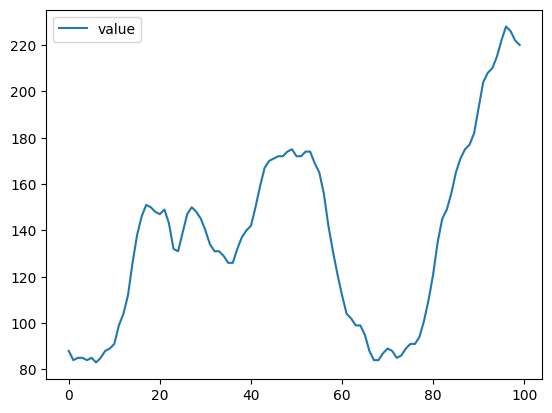

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();

Bu soyut zaman serisi mevsimsel görünmüyor, ancak artan bir trend ve bir şekilde "yapışkan" (yani biraz oto-regresif) özellikler gösteriyor. Bu nedenle Oto-Regresif Hareketli Ortalama (ARIMA) modelleri için iyi bir aday olabilir.

## 2. ARIMA Modeli Oluşturma
ARIMA modelleri (Oto Regresif Entegre Hareketli Ortalama) sayesinde verileri tahmin etmeye çalışacağız.

Bunun için şunları yapmamız gerekecek:
1. zaman serisini nasıl durağanlaştırılacağını bulma (ARIMA'daki I)
2. oto-regresif (AR) kısmını bulma
3. hareketli ortalama (MA) kısmını bulma
4. Uydurma
5. Performansı değerlendirme

### Adım 1 - Durağanlığı Sağlama

ARIMA modelleri yalnızca "durağan" zaman serilerine uygulanır.

👉 [`Genişletilmiş Dickey-Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) kullanarak durağanlığını kesin olarak kontrol edin, özellikle p-değerini

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.4642397172033688
p-value: 0.12441935447109453


Durağanlıkta %95 güvenilirlik için p-değeri 0.05'ten küçük olmalıdır.
P-değeri 0.05'ten büyükse, boş hipotezi reddedemeriz (boş hipotez = "süreç durağan değildir").

Zaman serisi durağan değilse, **farklaştırma** yoluyla durağanlaştırılması gerekir.
- Bu, her değer ile bir önceki değer arasındaki farkı almak anlamına gelir (*birinci fark*).
- *İkinci fark* istiyorsanız, farklaştırılmış seri üzerinde işlemi tekrarlayın, vb...

👉 Durağan hale getirmek için ihtiyacımız olan minimum farklaştırma sırasını bulun (görselleştirmek için eğrileri çizin ve emin olmak için adfuller p-değerlerini yazdırın)

<details>
    <summary>İpucu</summary>

`pd.Series.diff`
</details>

<Axes: >

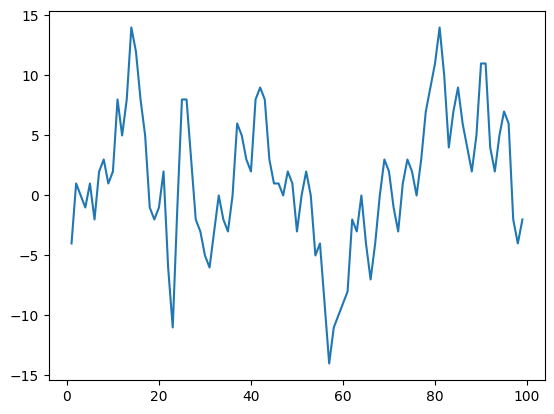

In [5]:
y_diff1 = y.diff().dropna()
y_diff1.plot()

Burada bir ve iki fark sırası arasında yakın bir durumumuz var. Zaman serilerini fazla farklaştırmak ARIMA modellerinizin performansını da düşürebilir. Daha yakından bakalım:

👉 1. ve 2. fark sırası için otokorelasyon grafiğini ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) çizin.

(💡Profesyonel ipucu: Her statsmodels grafiği örneklemesinin sonuna `;` ekleyerek veya `plt.show()` çağırarak statsmodels grafiklerinin çoğaltılmasından kaçının)

In [6]:
result_diff1 = adfuller(y_diff1)
print("ADF Statistic (1st diff):", result_diff1[0])
print("p-value (1st diff):", result_diff1[1])

ADF Statistic (1st diff): -2.722238490442953
p-value (1st diff): 0.07026846015272707


"İkinci sıra fark" otokorelasyon grafiğimizde, 1 numaralı gecikme katsayısı 0'a yakın, ikincisi ise negatif bölgeye kadar uzanıyor. Bu, seriyi aşırı farklaştırdığımızı gösterebilir. (Unutmayın: her zaman 1'e eşit olan 0 numaralı gecikmeyİ hiçbir zaman umursamayız)

👉 (Geçici olarak) yalnızca bir fark sırasını tutalım ve bu seriyi `y_diff` olarak adlandıralım (daha sonra her zaman daha fazla fark deneyebiliriz)

In [7]:
y_diff = y.diff().dropna()

Az önce ARIMA'daki "I" terimini bulduk: durağan olmadan önce 1-fark için `d = 1` ("I", "entegrasyon"u ifade eder, "d" farklaştırma için...)

### Adım 2 - AR sırası (p) ve MA sırasını (q) seçin

#### MA($\color{blue}{q}$) = $Y^{\color{green}{(d)}}$'nin $\color{blue}{ACF}$'inin kesildiği gecikme sayısı

MA sırası (`q`), `y_diff`'e uygulanan otokorelasyon grafiğine ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bakılarak bulunabilir.

👉 `q`'yu belirleyin

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

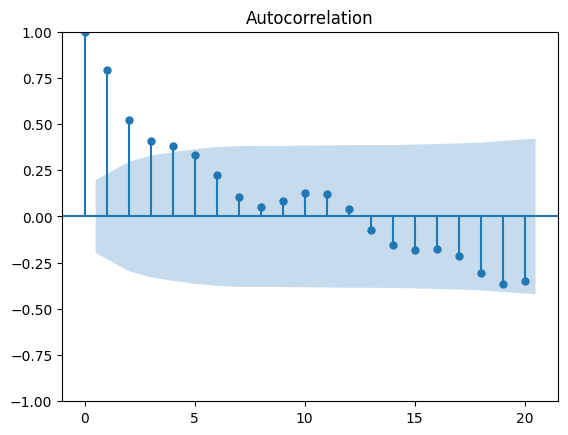

In [9]:
plot_acf(y_diff1, lags=20)
plt.show()

Modelimizi uydurma için değerlendirmemiz gereken maksimum değer q = 4 gibi görünüyor. Ancak, Otomatik-ARIMA kullanacak olsaydık (bu konuda daha sonra ayrıntılı bilgi), q=2 kullanmanın ideal sonuçlar verdiğini görürdük, bu nedenle başlangıçta q=2 ayarlamayı deneyelim.

Şüpheniz olduğunda, Y'yi yeterince açıklayan daha basit modeli seçin.

#### AR($\color{red}{p}$) = $Y^{\color{green}{(d)}}$'nin $\color{red}{PACF}$'inin kesildiği gecikme sayısı

AR sırası (`p`), `y_diff`'e uygulanan **k**ısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) incelenerek bulunabilir.

(Kısmi otokorelasyon, ara gecikmelerin katkılarını hariç tuttuktan sonra seri ile gecikmesi arasındaki korelasyon olarak düşünülebilir. Yani, PACF bir şekilde bir gecikme ile seri arasındaki saf korelasyonu iletir)

👉 `p`'yi belirleyin

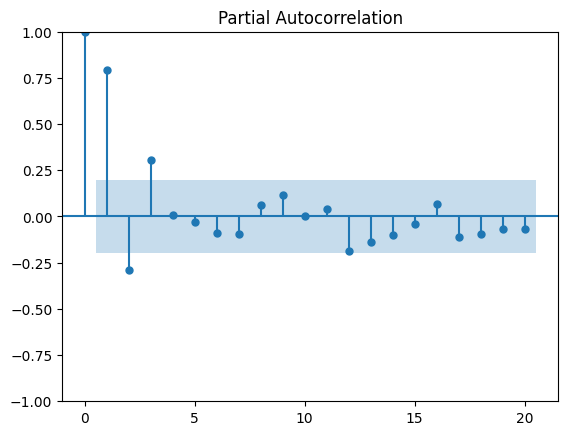

In [10]:
plot_pacf(y_diff1, lags=20)
plt.show()

İlk 3 gecikme terimi anlamlılık düzeyinin üstünde göründüğü için `p = 3` seçebiliriz, ancak daha basit bir model `p = 1` ile de gidebiliriz.

### Adım 3 - Modeli oluşturun

Artık ARIMA için `p`, `d` ve `q` değerlerini seçtiğinize göre,

👉 `statsmodels`'den `arima_model`'i oluşturun.
- modeli uydurur
- modeli yazdır (`.summary`)

In [11]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(1, 1, 2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Fri, 16 Jan 2026   AIC                            516.253
Time:                        11:50:35   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

☝️ P-değerleriniz çok yüksekse, karşılık gelen AR veya SA katsayılarını azaltarak bu terimleri kaldırmayı deneyin.

[`AIC - Akaike Bilgi Kriteri`](https://medium.com/towardsdatascience/the-akaike-information-criterion-c20c8fd832f2) değerini en aza indirerek uyumunuzun genel performansını değerlendirebilirsiniz

(1,1,1) ARIMA modellerinin aşırı uydurmaya karşı daha az şansı olduğu (p-değerleri düşük kalır) ve diğer modellerden neredeyse benzer bir AIC puanı koruduğu görülüyor

## 3. Model performansını değerlendirin

👉 `plot_predict()` yöntemi ile model tahminlerinizi görselleştirin

- Yöntemin varsayılan parametrelerine, özellikle `dynamic` parametrelerine yakından bakın.
- Modelinizin gerçekte böyle iyi bir performansa sahip olacağını düşünüyor musunuz?

In [12]:
from statsmodels.graphics.tsaplots import plot_predict

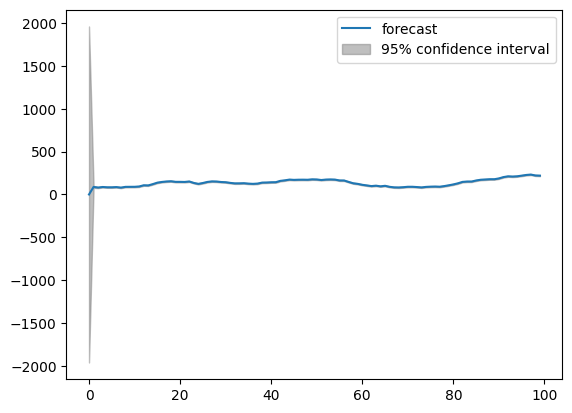

In [13]:
plot_predict(model_fit, start=0, end=len(y)-1)
plt.show()

☝️ `dynamic=False`, `y_pred`'i tahmin etmek için mevcut tüm `y` değerlerini kullanır, bu da ARIMA tahminizin $y_t$'yi tahmin etmek için $y_{t-1}$'e kadar kullanmasını sağlar. Gerçekte, özellikle gelecekte birkaç aralığı tahmin etmek istiyorsanız tüm `y`'ye erişiminiz yoktur.

👉 Modelin yalnızca _85'e kadar verilere erişimi_ olan bir durumda _son 15 değeri_ tahmin eden bir tahmini çizmek için `dynamic=True` kullanmayı deneyin. Yani model:
- gerçek [1...85]'e dayalı olarak 86'yı tahmin eder
- sonra 86 için önceden tahmin ettiği değer _artı_ [1...85]'e dayalı olarak 87'yi tahmin eder
- vb...100'e kadar yinelemeli olarak

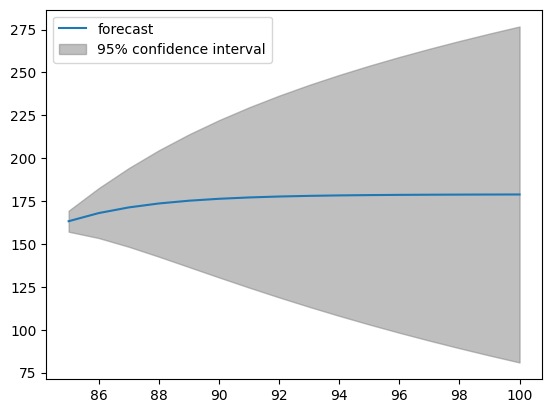

In [14]:
plot_predict(model_fit, start=85, end=100, dynamic=True)
plt.show()

☝️ Bu hala _gerçek_ bir tahmin değil! Neden?

<details>
    <summary>Cevap</summary>

Modelimiz uyum aşamasında tüm `y_true` serisini "gördü"!
</details>

### 3.1 Örneklem Dışı Tahminler (gerçek "gelecek")

👉 Test seti için yalnızca son 15 veri noktasını tutarak bir eğitim-test bölümü oluşturun ve ARIMA'nızı yalnızca eğitim setinde eğitin.

In [15]:
train = y.iloc[:-15]
test = y.iloc[-15:]

In [16]:
model_train = ARIMA(train, order=(1, 1, 2))
model_train_fit = model_train.fit()

👉 Şimdi 85. adımdayız ve geleceği hiç görmedik:
- Sonraki 15 veri noktasını (yani eğitim veri setinizin sonundan sonrasını) "tahmin etmek" için uydurduğunuz `arima` modelinde `get_forecast()` yöntemini kullanın

Yöntem `statsmodels`'den bir `PredictionResultsWrapper` nesnesi döndürür.

**💻 Bu sonucu `forecast_results` adlı bir değişkende saklayın.**

İlk başta gezinmek zordur, ancak işte bazı ipuçları:
- Tahminlerinizi `forecast_results.predicted_mean`'de bulabilirsiniz
- Güven aralıklarınız `forecast_results.conf_int()` tarafından verilir

In [17]:
forecast_results = model_train_fit.get_forecast(steps=15)

y_pred = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

👉 Tahmin edilen değerleri ve ayrıca %95 belirsizlik aralığının üst ve alt aralığını çizin

👉 Model performansını geçmişe göre daha iyi kavramak için önceki 85 `y` gerçek veri noktanızı da çizmeyi deneyin

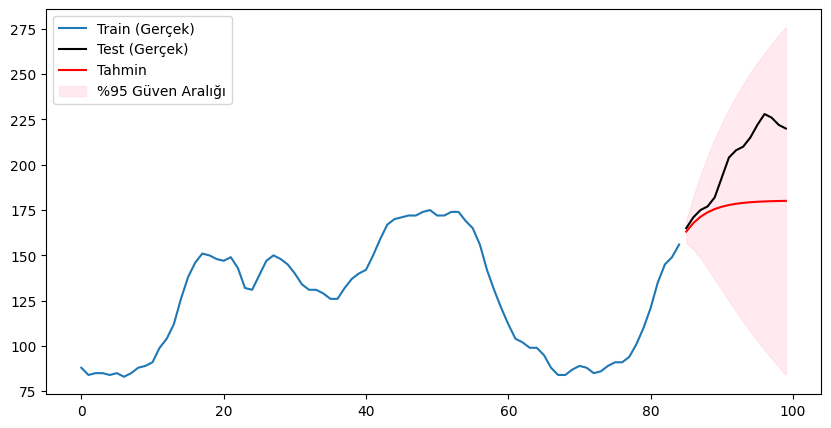

In [18]:
plt.figure(figsize=(10, 5))

# geçmiş gerçek veriler (ilk 85)
plt.plot(train.index, train, label="Train (Gerçek)")

# test (gerçek ama modele gösterilmedi)
plt.plot(test.index, test, label="Test (Gerçek)", color="black")

# tahmin
plt.plot(y_pred.index, y_pred, label="Tahmin", color="red")

# güven aralığı
plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="pink",
    alpha=0.3,
    label="%95 Güven Aralığı"
)

plt.legend()
plt.show()

### 3.2 %95 güven aralığınıza güvenebilir misiniz? (çıkarım koşulları)

👉 Hiçbir örüntü olmadığından emin olmak için artıkları `model.resid` çizin
- Normal dağılım
- Sıfır ortalama
- Tekdüze varyans
- Oto-regresif örüntü yok (isterseniz artıkları plot_acf yapabilirsiniz)

Not: artıklar `plot_predict(dynamic=False)`'daki gibi tüm verileri 'görerek' oluşturulur

Ayrıca, artıkların yaklaşık olarak normal dağılımda olup olmadığını görmek için artıkların bir histogramını veya KDE uyumunu çizmeyi deneyin.

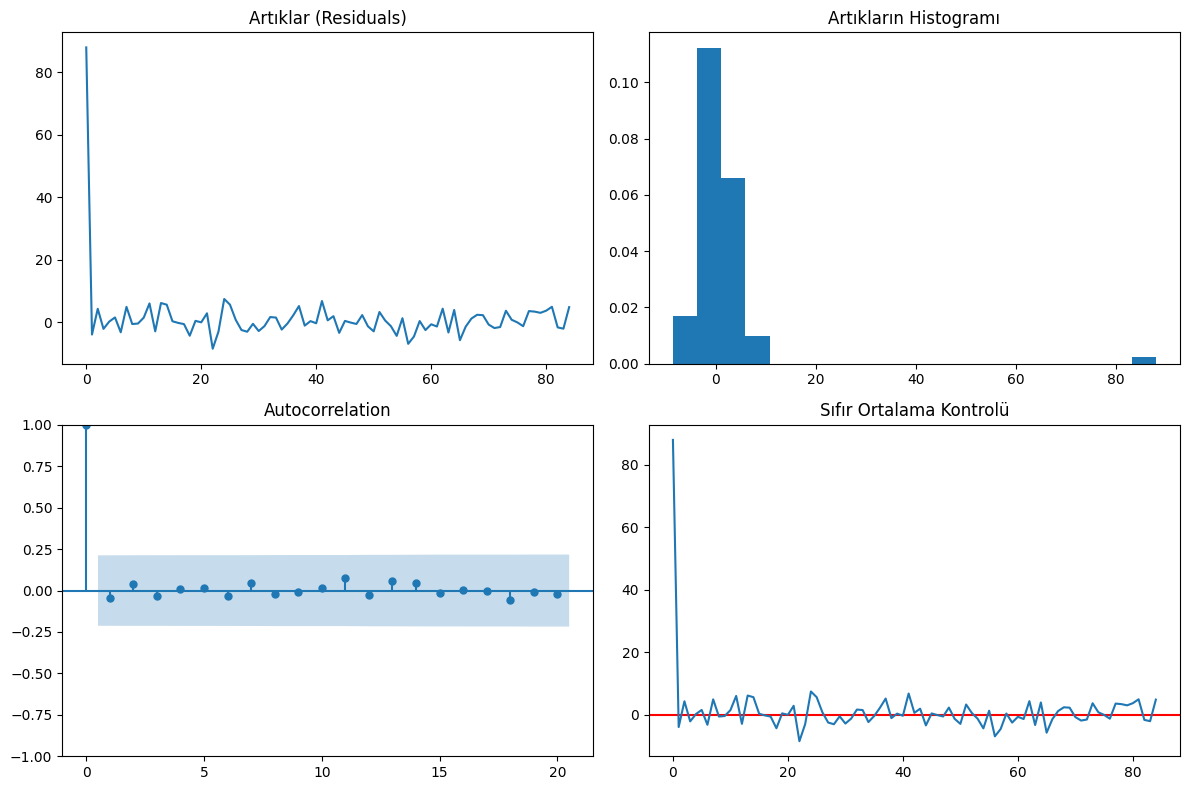

In [19]:
resid = model_train_fit.resid

plt.figure(figsize=(12, 8))

# 1) Artıkların zaman grafiği
plt.subplot(2, 2, 1)
plt.plot(resid)
plt.title("Artıklar (Residuals)")

# 2) Histogram (yaklaşık normal mi?)
plt.subplot(2, 2, 2)
plt.hist(resid, bins=20, density=True)
plt.title("Artıkların Histogramı")

# 3) ACF (otokorelasyon var mı?)
plt.subplot(2, 2, 3)
plot_acf(resid, lags=20, ax=plt.gca())

# 4) Ortalama sıfıra yakın mı?
plt.subplot(2, 2, 4)
plt.axhline(0, color="red")
plt.plot(resid)
plt.title("Sıfır Ortalama Kontrolü")

plt.tight_layout()
plt.show()

## 3.3 Çapraz doğrulanmış performans ölçümleri

👉 Aşağıda zaman serileri için en yaygın performans ölçümleri yer almaktadır

In [20]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

👉 ARIMA hiper-parametrelerinizle oynayın ve tahmin performansınız üzerindeki etkisini görün

In [21]:
forecast_accuracy(y_pred, test)

{'mape': 0.11663891091024665,
 'me': -25.042880458539646,
 'mae': 25.042880458539646,
 'mpe': -0.11663891091024665,
 'rmse': 30.264525270880362,
 'acf1': 0.8723950114391446,
 'corr': 0.9008321659471048,
 'minmax': 0.1166389109102467}

## 4 Izgara Arama

`pmdarima` kullanarak (p,d,q) için bir Izgara Arama çalıştırmayı deneyin. En azından şunları kullanın:
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [23]:
model = pm.auto_arima(
    train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,
    test='adf',
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(model.summary())

/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/pytho

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.02 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.259 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Fri, 16 Jan 2026   AIC                   

/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## (İsteğe bağlı) Modelinizin Performansını Çapraz Doğrulayın

Pratikte, sonuçlar ve Izgara Arama her zaman çapraz doğrulanmalıdır:

Modelinizin performansını gerçekten değerlendirmek ve çapraz doğrulamadan sonra en iyi hiperparametreleri bulmak için bitişik K-katlar oluşturmak amacıyla [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) kullanmaktan çekinmeyin.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - TimeSeriesSplit + Izgara Arama kullanarak Çapraz Doğrulama**

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

tscv = TimeSeriesSplit(n_splits=3)

results = []

for p in [0, 1, 2]:
    for d in [1]:
        for q in [0, 1, 2]:
            for fold, (train_idx, test_idx) in enumerate(tscv.split(y)):
                y_train_cv = y.iloc[train_idx]
                y_test_cv = y.iloc[test_idx]

                try:
                    model = ARIMA(y_train_cv, order=(p, d, q))
                    model_fit = model.fit()

                    results.append({
                        "p": p,
                        "d": d,
                        "q": q,
                        "fold": fold,
                        "AIC": model_fit.aic
                    })
                except:
                    continue

df_results = pd.DataFrame(results)
df_results

/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters f

,p,d,q,fold,AIC
0,0,1,0,0,153.994909
1,0,1,0,1,302.551983
2,0,1,0,2,461.217269
3,0,1,1,0,140.033331
4,0,1,1,1,268.840100
5,0,1,1,2,407.332315
6,0,1,2,0,139.489647
7,0,1,2,1,259.937948
8,0,1,2,2,390.528038
9,1,1,0,0,138.206436


In [26]:
df_results.sort_values("AIC").groupby(["p", "d", "q"]).mean()["AIC"].sort_values()

p  d  q
1  1  1    262.220148
0  1  2    263.318544
1  1  2    263.775721
2  1  1    263.980393
      2    264.604534
      0    264.944143
1  1  0    267.314014
0  1  1    272.068582
      0    305.921387
Name: AIC, dtype: float64

☝️ İlk model seçimimiz (1, 1, 2) çok da kötü değil!
Veri seti (100 veri noktası) gerçekte herhangi bir şeyi çapraz doğrulamak için çok küçük olduğuna dikkat edin!